A fine-tuned language model for pictionary word list completion (topic/category phrase + example words -> list of 30 examples). For example, one may complete the list

"A list of round fruits: peach, apricot, lime, plum,"

with

"mango, cherry, pineapple, strawberry, pumpkin, watermelon, orange, pomegranate, melon, apple, pear, grapefruit, papaya, lemon, kiwi, passionfruit, blueberry, raspberry, blackberry, cantaloupe, nectarine, pitaya, persimmon, durian, guava, jackfruit, avocado, lychee, soursop, guarana, mangosteen, blackcurrant, cranberry"

using this model. These words should be compatible with pictionary/skribbl.io; i.e., "sketchable" within a few minutes, and easily recognisable. Scroll to the end for more examples, or see the file `data/examples.txt`. Sketchability parameter estimation examples can also be found in `data/data.tsv`.

In [1]:
# import openai
# with open('../../openai-api-org.txt', 'r') as f: openai.organization = f.read()
# with open('../../openai-api-key.txt', 'r') as f: openai.api_key      = f.read()

In [2]:
import csv
import time
import glob
import string
import jsonlines
import numpy as np
import pandas as pd
import torch as pt
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from IPython.utils import io
from IPython.display import clear_output
from transformers import GPT2ForSequenceClassification, GPT2LMHeadModel, GPTNeoForCausalLM, ReformerModelWithLMHead, \
                         get_linear_schedule_with_warmup, GPT2TokenizerFast, AutoTokenizer, XLNetLMHeadModel
from pytorch_transformers import GPT2Tokenizer
from Learning import *


Complete.


[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
                                                  ###   Options   ###
model_name = "ernst_one"
# model_name = "unfinetuned"
modelkey = "xlnet-large-cased"                   # Pretrained model to start from
# modelkey = "gpt2-xl"
modelclass = "XLNetLMHeadModel"
# modelclass = "GPT2LMHeadModel"
val_frac, test_frac = 0.25, 0.25    # Fraction of samples to keep as separate validation/test set (word lists)
TsN = 200                           # Number of randomly generated prompts for each sample when validating model
log_period_batches = 10             # Batches per iteration
# learning_rate = 5e-7              # Adam learning rate (default is 5e-5, sentiment classification example had 2e-5)
learning_rate = 2e-5
# learning_rate = 4e-6
adam_epsilon = 1e-8                 # Adam epsilon (default is 1e-8)
n_sched_warmup = 0                  # Linear scheduler for optimizer number of warmup steps
batch_size = bsz = 64               # Samples per batch
# batch_size = bsz = 32
# batch_size = bsz = 4
# N_train_batches = int(1e7 / bsz)  # Total number of batches to show model
N_train_batches = 600
n_unfreeze = "all"                  # Number of model layers to fine tune, in addition to the last output linear layer
# max_len = 1024                    # Max n. tokens applied prior to rng_train (number of phrases range)
max_len = 32
train_phrase_log_pctile = 0.0       # Phrase generation probability percentile excluded from training dataset
lidstone_eps = 0.01                 # Smoothing epsilon for possible words/subwords which are not in the missing list words set
lastcomma_repl = ',' # 'EOS', ','   # Token optionally used to replace the final comma that ends the generated phrase
use_correct_nouns = True            # Whether to use only correct singular or plural form of category nouns for the given prompt
swap_noun = False                   # Whether to swap plural and singular nouns in prompt
# rng_train = [0, 512]              # Range of prompt list lengths (number of phrases) to generate for training data
rng_train = [3, 5]

In [4]:
dev = "cuda" if pt.cuda.is_available() else "cpu"  # Setup torch device(s)
d = device = pt.device(dev)
# world_size = 1
# rank = 0
# def setup(rank, world_size): 
#     os.environ['MASTER_ADDR'] = '127.0.0.1'
#     os.environ['MASTER_PORT'] = find_free_port()
#     dist.init_process_group("gloo", rank=rank, world_size=world_size)  # initialize the process group
# def cleanup():
#     dist.destroy_process_group()
# # mp.spawn(setup, args=(rank, world_size), nprocs=world_size)
# setup(rank, world_size)

In [5]:
cats, cats_sing, phrases = Listset().load()  # Import word lists dataset

In [6]:
gpt3_tokenizer = GPT2TokenizerFast.from_pretrained(("gpt2-large"))
with io.capture_output() as captured:
    tokenizer = AutoTokenizer.from_pretrained(modelkey.replace("-xl", "-large"))
tokenizer.encode("A list of round fruits: apples, oranges, pears,"), \
    tokenizer.encode("A list of round fruits: apples,"), tokenizer.encode("oranges, pears,"), \
  gpt3_tokenizer.encode("A list of round fruits: apples, oranges, pears,"), \
    gpt3_tokenizer.encode("A list of round fruits: apples,"), \
    gpt3_tokenizer.encode("oranges, pears,") # Note: gpt-3 tokenizes words differently if they are at the start of the sentence

([79, 649, 20, 866, 10164, 60, 18907, 19, 6090, 23, 19, 25571, 23, 19, 4, 3],
 [79, 649, 20, 866, 10164, 60, 18907, 19, 4, 3],
 [6090, 23, 19, 25571, 23, 19, 4, 3],
 [32, 1351, 286, 2835, 15921, 25, 22514, 11, 48389, 11, 279, 4127, 11],
 [32, 1351, 286, 2835, 15921, 25, 22514, 11],
 [273, 6231, 11, 279, 4127, 11])

In [7]:
class DerivTokenizer(tokenizer.__class__):  # Wrap the tokenizer so that we don't produce the special tokens (NLG case)
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def __len__(self): return self.tokenizer.__len__()
    def encode(self, *args, **kwargs): return self.tokenizer.encode(*args, **{**kwargs, **{"add_special_tokens": False}})
    def decode(self, *args, **kwargs): return self.tokenizer.decode(*args, **kwargs)
tokenizer, gpt3_tokenizer = DerivTokenizer(tokenizer), DerivTokenizer(gpt3_tokenizer)
lprompts_sing = [p for p in lprompts if (("types of" in p) ^ swap_noun)]
enc_prompts = lambda tknzr, prmts: [pt.tensor(tknzr.encode(p)).to(d) for p in prmts]
enc_listset = lambda tknzr, Xs: [[[pt.tensor(tknzr.encode(p + suffix)).to(d) for p in ps] for ps in X] for (X, suffix) in Xs]
lprompts_encoded, lprompts_encoded3 = enc_prompts(tokenizer, lprompts), enc_prompts(gpt3_tokenizer, lprompts)
lprompts_sing_encoded, lprompts_sing_encoded3 =enc_prompts(tokenizer, lprompts_sing),enc_prompts(gpt3_tokenizer, lprompts_sing)
Xs = (cats, ': '), (cats_sing, ': '), (phrases, ', ')
(cats_e,cats_sing_e,phrases_e), (cats_e3,cats_sing_e3,phrases_e3) = enc_listset(tokenizer, Xs), enc_listset(gpt3_tokenizer, Xs)
comma_token = pt.tensor(tokenizer.encode("a,")[1], device=d)
N_tokens = len(tokenizer)
N_wordlists = len(cats)
lidstone_eps = pt.tensor(lidstone_eps, device=d) if not isinstance(lidstone_eps, pt.Tensor) else lidstone_eps
lidstone_value = lidstone_eps / N_tokens
y_zero = (lidstone_value).repeat(N_tokens)

In [8]:
all_phrases = list(set(sum(phrases, [])))
vowels = 'aeiuo'
# phrase_logs = get_s_avglogs([('An' if p[0].lower() in vowels else 'A') + ' ' + p for p in all_phrases])
phrase_logs = ()# todo: function to get log probability of phrase (n-gram) occuring in the pretraining dataset

In [9]:
use_max_plog = train_phrase_log_pctile > 0.0
if use_max_plog:
    max_phrase_log = np.percentile(phrase_logs, 100 * (1.0 - train_phrase_log_pctile))
    phrase_incls = [p > max_phrase_log for p in phrase_logs]
    phrase_incl = dict(zip(all_phrases, phrase_incls))
    all_phrases_enc = sum([[tuple(p_.cpu().detach().numpy().tolist()) for p_ in p] for p in phrases_e], [])
    enc_phrase_log_incl = dict(zip(list(set(all_phrases_enc)), phrase_incls))
    plt.hist(phrase_logs, bins=250)
    plt.axvline(x=max_phrase_log, color='red')
    plt.show()

In [10]:
# Generate a fixed test set and save to disk. This function defines the next list token prediction problem
def gen_truncated_list(prmt, p, ra=True, rng=rng_train, mlen=max_len):  # prmt = prompt tokens, p = list phrase/word tokens
    tkzs, sent, tkix, wordix = [], [], 0, -1   # rng is the inclusive range of list lengths to generate (number of phrases)
    min_nw, max_nw, min_nt, max_nt = rng[0], int(rng[1]), 0, int(mlen) - len(prmt)
    incl_words = np.random.choice(len(p), min(len(p), max_nw), replace=False)
    if use_max_plog:
        p_ra = [i for i in range(len(p)) if enc_phrase_log_incl[tuple(p[i].cpu().detach().numpy().tolist())]]
        p_incl = [i for i in range(len(p)) if i not in p_ra]
        p_ra_chosen = [i for i in incl_words if i in p_ra]
        min_nw -= len(p_ra_chosen)
        incl_words = [i for i in incl_words if i in p_incl]
    if len(incl_words) == 0:#rare when train_phrase_log_pctile is low enough and min_nw is high enough (temporary optimisation)
        return gen_truncated_list(prmt, p, ra=ra, rng=rng, mlen=mlen)
    for phz_i in incl_words:
        phz_enc, wordix = p[phz_i], wordix + 1
        tkzs.append((tkix, phz_enc)), sent.append(phz_enc)
        tkix += len(phz_enc)
        if wordix < min_nw: min_nt = tkix
        if tkix >= max_nt:
            tkix = max_nt
            break
    if min_nt - 1 >= tkix:  # rare when max_len is large enough (0.5x max possible total list length) (temporary optimisation)
        return gen_truncated_list(prmt, p, ra=ra, rng=rng, mlen=mlen)
    sent = pt.hstack(sent)[:max_nt]
    # If we don't want to include outliers in target
    missing_w = [p[i] for i in range(len(p)) if (i not in incl_words) and (True if (ra or not use_max_plog) else (i in p_incl))]
    trunc_ix = np.random.randint(max(min_nt - 1, 0), tkix)
    trunc_n = min([(trunc_ix - ix) for (ix, enc) in tkzs if ix <= trunc_ix])  # N. end phrase tokens
    missing_w += [enc for (ix, enc) in tkzs if ix >= (trunc_ix - trunc_n)]
    missing_matches = missing_w
    if trunc_n > 0:
        phr_start = trunc_ix - trunc_n
        partial_phr = sent[phr_start:trunc_ix]
        missing_matches = [enc for enc in missing_w if len(enc) >= trunc_n and all(enc[:trunc_n] == partial_phr)]
    next_tokens = [enc[trunc_n] for enc in missing_matches]
    norm = len(next_tokens) * (1.0 + lidstone_eps)
    tunit, y_ = pt.tensor(1 / norm, device=d), y_zero.clone()
    for token in next_tokens: y_[token] += tunit
    return pt.hstack([prmt, sent[:trunc_ix]]), y_
def stac_sample(stac, n):   # Create batches by random permutations (maximise diversity and uniformity) (shuffling done later)
    r, mode, total = [], tuple(np.unique(stac)), stac.shape[0]
    while n > 0:
        if mode == (0,) or mode == (1,) or mode == (-1,):
            if n >= total:
                new = sum([list(range(total)) for _ in range(n // total)], [])
                r += new
                n -= len(new)
            else:
                new = np.random.choice(total, n, replace=False)
                stac[new] = (mode[0] + 1) if mode != (1,) else -1
                r += new.tolist()
                n = 0
        else:
            old_val, new_val = mode[0] if mode != (-1, 1) else 1, mode[1] if mode != (-1, 1) else -1
            old_i = np.nonzero(stac == old_val)[0]
            if n >= old_i.shape[0]:
                stac[old_i] = new_val
                r += old_i.tolist()
                n -= old_i.shape[0]
            else:
                new = np.random.choice(old_i, n, replace=False)
                stac[new] = new_val
                r += new.tolist()
                n = 0
        mode = tuple(np.unique(stac))
    return r
def gen_listname(cp, cp_cs, prompt, prmt, tknzr=tokenizer):
    cat_ix = np.random.randint(len(cp_cs))            # First uniformly sample a category title
    sing = use_correct_nouns and (cat_ix >= len(cp))  # Singular vs plural prompt prefix
    if prompt is None:                                # Uniformly sample a list beginning phrase ("A list of...") if not given
        lprmpts = ((lprompts_sing_encoded if sing else lprompts_encoded) if tknzr is tokenizer else \
                   (lprompts_sing_encoded3 if sing else lprompts_encoded3)) if tknzr is not None else \
                   (lprompts_sing if sing else lprompts)
        prmt = lprmpts[np.random.randint(len(lprmpts))]
    return cp_cs[cat_ix], prmt
def gen_listnames_uniform(xcp, xcs, xp, n, prompt=None, tknzr=tokenizer, verbose=False, stac=None):
    prmts, cats, ps, j, prmt = [], [], [], 0, None
    if prompt is not None and tknzr is not None: prmt = pt.tensor(tknzr.encode(prompt), device=d)
    stac_, stac = stac_sample(stac, n) if (stac is not None) else None, stac is not None
    if stac: np.random.shuffle(stac_)
    for i in (range(len(xcp)) if not stac else stac_):
        prmts_, cats_ = [], []
        cp, cs, p = xcp[i], xcs[i], xp[i]
        cp_cs = cp + cs
        for m in range(n if not stac else 1):
            cat, prmt = gen_listname(cp, cp_cs, prompt, prmt, tknzr=tknzr)
            prmts_.append(prmt), cats_.append(cat)
            j += 1
            if verbose and j % 100 == 0: sys_print("\rGenerating list names, done: " + str(j))
        ps.append(p), prmts.append(prmts_), cats.append(cats_)
    if verbose: sys_print("\rGenerating list names, done: " + str(j) + ", finished!\n")
    return prmts, cats, ps, stac
def gen_samples_uniform(xcp, xcs, xp, n,              # Weight testing samples (word lists) exactly uniformly
                        ra=True, rng=rng_train, prompt=None, tknzr=tokenizer, verbose=False, inds=False, stac=None, mlen=1e9):
    xs, ys, sqlens, j, prmt = [], [], [], 0, None
    prmts, cats, ps, stac = gen_listnames_uniform(xcp, xcs, xp, n, prompt=prompt, tknzr=tknzr, verbose=verbose, stac=stac)
    for i in range(len(prmts)):
        x, y, sqlen, p = [], [], [], ps[i]
        for k in range(len(prmts[i])):
            x_, y_ = gen_truncated_list(pt.hstack([prmts[i][k], cats[i][k]]), p, ra=ra, rng=rng, mlen=mlen)
            x.append(x_), y.append(y_), sqlen.append(len(x_))
            j += 1
            if verbose and j % 100 == 0: sys_print("\rGenerating list elements, done: " + str(j))
        xs.append(x), ys.append(y), sqlens.append(sqlen)
    if inds or stac: xs, ys, sqlens = sum(xs, []), sum(ys, []), sum(sqlens, [])
    if verbose: sys_print("\rGenerating list elements, done: " + str(j) + ", finished!\n")
    return (xs, ys, sqlens, np.arange(len(xcp)).repeat(n)) if inds else (xs, ys, sqlens)
def gen_samples(xcp, xcs, xp, n,
                ra=True, rng=rng_train, prompt=None, tknzr=tokenizer, inds=False, mlen=1e9):
    xs, ys, sqlens, j, prmt = [], [], [], 0, None   
    if prompt is not None and tknzr is not None: prmt = pt.tensor(tknzr.encode(prompt), device=d)
    xs, ys, sqlens, j = [], [], [], 0
    n_sets, indices = len(xcp), []
    for m in range(n):  # Maximise per-batch training diversity by randomly sampling the word lists
        i = np.random.randint(n_sets)
        cp, cs, p = xcp[i], xcs[i], xp[i]
        cp_cs = cp + cs
        cat_ix, prmt = gen_listname(cp, cp_cs, prompt, prmt)
        x_, y_ = gen_truncated_list(pt.hstack([prmt, cp_cs[cat_ix]]), p, ra=ra, rng=rng, mlen=mlen)
        xs.append(x_), ys.append(y_), sqlens.append(len(x_)), indices.append(i)
    return (xs, ys, sqlens, np.asarray(indices)) if inds else (xs, ys, sqlens)

In [11]:
N_test, N_val = int(test_frac * N_wordlists), int(val_frac * N_wordlists)
N_train = N_wordlists - N_test
# test_idx = np.random.choice(N_train, N_test, replace=False)
test_idx = np.asarray([ 2,  8, 21,  4,  7,  5, 10, 25])
save_ld(test_idx, "test_idx")
# test_idx = load_ld("test_idx")
trval_idx = np.asarray([i for i in range(N_wordlists) if i not in test_idx])
# val_idx = np.random.choice(trval_idx, N_val, replace=False)
val_idx = np.asarray([14, 11,  1, 19, 24, 31, 18, 32])
save_ld(val_idx, "val_idx")
# val_idx = load_ld("val_idx")
train_idx = np.asarray([i for i in trval_idx if i not in val_idx])
print(test_idx, val_idx)
print(*sum([[c+'\n',[cats[i][0] for i in ix]]for(c,ix)in[["Train",train_idx],["\nValidation",val_idx],["\nTest",test_idx]]],[]))
index_listset, listset_iXs = lambda inds, Xs: [[X[i] for i in inds] for X in Xs],("trval_idx","train_idx","val_idx","test_idx")
phase_listsets = {None: {k[:-4]: index_listset(globals()[k], (cats, cats_sing, phrases)) for k in listset_iXs},
             "default": {k[:-4]: index_listset(globals()[k], (cats_e, cats_sing_e, phrases_e)) for k in listset_iXs},
                "gpt3": {k[:-4]: index_listset(globals()[k], (cats_e3, cats_sing_e3, phrases_e3)) for k in listset_iXs}}
cats_e_test, cats_sing_e_test, phrases_e_test = phase_listsets["default"]["test"]
cats_e_val, cats_sing_e_val, phrases_e_val = phase_listsets["default"]["val"]
val_cats = [cats[i][0] for i in val_idx]
test_xs,test_ys,test_sqlens= gen_samples_uniform(cats_e_test, cats_sing_e_test, phrases_e_test, TsN, mlen=max_len, verbose=True)
val_xs, val_ys, val_sqlens = gen_samples_uniform(cats_e_val, cats_sing_e_val, phrases_e_val, TsN, mlen=max_len, verbose=True)

[ 2  8 21  4  7  5 10 25] [14 11  1 19 24 31 18 32]
Train
 ['round fruits', 'microorganisms', 'outback experiences', 'buildings', 'holed pasta', 'rod shaped pasta', 'sounds of a building', 'biological examples of math in nature', 'non-biological examples of math in nature', 'handcrafts', 'communication media', 'storage media', 'scientific principles behind showers', 'scientific principles behind rain showers', 'spacecraft types', 'real spacecrafts', 'interpersonal tokens of trust'] 
Validation
 ['construction sounds', 'hats', 'wild animals', 'woodland ecoregions', 'winds', 'physical tokens that confer trust', 'timbers', 'digital tokens that confer trust'] 
Test
 ['chemical elements', 'dramatic and literature elements', 'vehicles referred to as crafts', 'music', 'scientific cycles', 'machine learning algorithms', 'glassware', 'windings']
Generating list names, done: 1600, finished!


/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Generating list elements, done: 1600, finished!
Generating list names, done: 1600, finished!
Generating list elements, done: 1600, finished!


In [12]:
# write function that takes a prompt, existing list and sampling params and returns gpt3's next token probs
default_msp = {
  "best_of": 1,
}
default_sp = {
  "temperature": 1.0,
  "top_p": 1.0,
#   "top_k": -1.0,                 # todo: add code to apply this to gpt3 output (top100), max k ~=90, min = 2?
  "presence_penalty": 0.0,
  "frequency_penalty": 0.0,
}
default_params = {
  "engine": "davinci",
  "model": None,
  "max_tokens": 1,
  "temperature": 1.0,
  "top_p": 1.0,
#   "top_k": -1.0,
  "presence_penalty": 0.0,
  "frequency_penalty": 0.0,
  "n": 1,
  "stream": False,
  "logprobs": 100,
#       "logit_bias": {"50256": -100},
  "stop": [",", "\n"],
}
# Define and test the OpenAI API next token probability request (response-token-efficient streaming version)
def format_gpt3_probs(choice, tokenize):
    res, r = [], sorted([(np.e**v, k) for (k, v) in choice["logprobs"]["top_logprobs"][0].items()])[::-1]
    for i in range(len(r)):
        k = gpt3_tokenizer.encode(r[i][1])
        if len(k) == 1: res.append((r[i][0], k if tokenize else r[i][1]))
    return res
def p_req(s, tokenize=False, **kwargs):
    use_stream = "max_tokens" in kwargs and kwargs["max_tokens"] != 1
    kwargs["prompt"], kwargs["stream"] = s, use_stream
    with io.capture_output() as captured:
        response, result = openai.Completion.create(**{**default_params, **kwargs}), []
    return [(np.e**resp["choices"][0]["logprobs"]["token_logprobs"][0], resp["choices"][0]["logprobs"]["tokens"][0],
             format_gpt3_probs(resp["choices"][0], tokenize)) for resp in (response if use_stream else [response])]
# todo: version to handle multiple choices for phrase level evaluation (response-token-expensive)
def p_req_m(s, tokenize=False, **kwargs):
    if "max_tokens" not in kwargs: kwargs["max_tokens"] = 8
    if "n" not in kwargs: kwargs["n"] = 5
    if "best_of" in kwargs:
        kwargs["best_of"] = int(round(kwargs["best_of"]))
        if kwargs["n"] != 1: kwargs["best_of"], kwargs["n"] = kwargs["n"], kwargs["best_of"]
    kwargs["prompt"] = s
    with io.capture_output() as captured:
        response, tokens, probs = openai.Completion.create(**{**default_params, **kwargs}), [], []
    for choice in response["choices"]:
        tks = [np.e**v for v in choice["logprobs"]["token_logprobs"]]
        tks = [(choice["logprobs"]["tokens"][i], tks[i]) for i in range(len(tks))]
        tokens.append(tks), probs.append(format_gpt3_probs(choice, tokenize))
    return tokens, probs

In [13]:
# a = p_req("A list of cyclic phenomena: day and night, induction coil, self-oscillation, tornado, runaway greenhouse effect,")
# b = p_req_m("A list of cyclic phenomena: day and night, induction coil, self-oscillation, tornado, runaway greenhouse effect,")
# print(sum([a_[0] for a_ in a[0][2]]))
# print(','.join([''.join([b__[0] for b__ in b_]) for b_ in b[0]] + [''.join([a_[1] for a_ in a])]).replace('\n', '⏎'))

In [14]:
# function that takes a completion distribution (top 100) and target next token distribution (multinomial) and computes the
# probability that the completion produces a desired output token
def prob_corr(pred_p, target_p):
    r = 0
    if isinstance(pred_p, list):
        for (p, token) in pred_p:
            if target_p[token] > (lidstone_value + 1e-10): r += p
    else:
        r = np.sum(target_p[np.nonzero(pred_p > (lidstone_value + 1e-10))[0]])
    return r
# directly computes the similarity between target and predicted token distributions
def score_corr(pred_p, target_p, distance="cross-entropy", redistribute_mass=False, include_negatives=False):  
    r = 0
    if isinstance(pred_p, list) and not redistribute_mass:
        for (p, token) in pred_p:
            targ = target_p[token]
            if targ > (lidstone_value + 1e-10) or include_negatives:
                if   distance == "unnormalized":  r -= p * targ
                elif distance == "cross-entropy": r -= p * np.log(targ)
                elif distance == "kl-divergence": r += p * np.log(p / targ)
                elif distance == "bhattacharyya": r += np.sqrt(p * targ)
        if distance == "bhattacharyya": r = -np.log(r)
    else:
        p = pred_p
        if isinstance(pred_p, list):
            p_ = np.asarray([p for (p, _) in pred_p])
            ts = np.asarray([t for (_, t) in pred_p])
            unaccounted_mass = 1.0 - sum(p_)
            n_missing_tokens = N_tokens - len(pred_p)
            p = np.repeat(unaccounted_mass / n_missing_tokens, N_tokens)
            p[ts] = p_
        if not include_negatives:
            pos = np.nonzero(target_p > (lidstone_value + 1e-10))[0]
            p, target_p = p[pos], target_p[pos]
        if   distance == "unnormalized":  r = -np.sum(p * targ)
        elif distance == "cross-entropy": r = -np.sum(p * np.log(target_p))
        elif distance == "kl-divergence": r =  np.sum(p * np.log(p / target_p))
        elif distance == "bhattacharyya": r = -np.log(np.sum(np.sqrt(p * target_p)))
    return -r
# probability that a completion phrase is a desired missing list entry
def prob_msp(outs, missing):
    correct = 0
    missing = set([phrase.lower() for phrase in missing])
    for i in range(len(outs)):
        out = outs[i].strip().lower()
        if out not in missing and (out[:4] == 'the '): out = out[4:]
        if out in missing: correct += 1
    return correct / len(outs)

In [15]:
lens = sum([[len(p) for p in p_ if len(p) < 1000] for p_ in phrases_e], [])  # Print longest list elements in dataset, get max
phrs = sum([[p for p in p_ if len(p) < 1000] for p_ in phrases_e], [])
m = np.max(lens)
inds = [i for i in range(len(phrs)) if lens[i] == m]
ree = [(tokenizer.decode(phrs[i].cpu().detach().numpy()), phrs[i].cpu().detach().numpy(), lens[i]) for i in inds]
phrl_max = len(ree[0][1]) - 1
pr(ree)
phrl_max

[   (   'filati cu lu pirtuso,',
        array([   17, 10291,  4807,    17,  3525,    17,  2311,    17,  9261,
        7077,   155,    19]),
        12)]


11

In [16]:
# function that takes sampling parameters, then generates n random incomplete list prompts (of length l), obtains completion
# distributions (top 100 tokens or full multinomial) and evaluates the average score across the n prompts. n = 20 by default
# All samples generated are stored fully for later training of sample-dependent sampling parameter (mixture) distribution
sps_ = ["top_p", "temperature", "presence_penalty", "frequency_penalty"]  # sampling params                          #top_k
msps_= sps_#["best_of"] + sps_                                                 # meta sampling params
create_folder(data_dir + learning_data_dir)
create_folder(data_dir + learning_data_dir + "sp_samples")
create_folder(data_dir + learning_data_dir + "sp_samples_test")
create_folder(data_dir + learning_data_dir + "msp_samples_nb")
create_folder(data_dir + learning_data_dir + "msp_samples_nb_test")
phaseIx = lambda phase: globals()[phase + '_idx']
def save_modeloutput(idx, dname, pnames, params, r, min_l, max_l, mdl, xs=None, ys=None, sqlens=None, inds=None, d=None):
    engine_str = ','.join([str(params[k]) for k in ["engine", "model"] if k in params])
    for i_raw in range(len(idx)):
        i = idx[i_raw]
        create_folder(data_dir + learning_data_dir + dname + "/" + str(i))
        ix, mdl_name = np.nonzero(inds == i_raw)[0], mdl if isinstance(mdl, str) else mdl["name"]
        fn = str(time.time()) + '_' + '_'.join([str(v) for v in [params[k] for k in pnames] + [min_l, max_l]]) + '_' + mdl_name
        input_data = [d[j] for j in ix] if d else [xs[ix], ys[ix], sqlens[ix]]
        save_ld((params, input_data, ix, [r[j] for j in ix], str(mdl)), dname + "/" + str(i) + "/" + fn, compress=9)
def eval_sp(params, min_l=0, max_l=1e9, n=20, prmt=None, phase="train", uniform=True, mdl='gpt3'):
    res, max_l = [], int(max_l), 
    tknzr = gpt3_tokenizer if mdl == "gpt3" else tokenizer
    xcp, xcs, xp = phase_listsets["gpt3" if mdl == "gpt3" else "default"][phase]
    xs, ys, sqlens, inds = gen_samples_uniform(xcp, xcs, xp, n, prompt=prmt, tknzr=tknzr, inds=True, rng=[min_l, max_l]) \
           if uniform else gen_samples        (xcp, xcs, xp, n, prompt=prmt, tknzr=tknzr, inds=True, rng=[min_l, max_l])
    if mdl == 'gpt3': r = [p_req(gpt3_tokenizer.decode(x_.detach().cpu().numpy()), **params) for x_ in xs] 
    else:             r = mdl["probabilities"](xs, ys, sqlens, **params)
    save_modeloutput(phaseIx[phase][np.unique(inds)], "sp_samples", sps_, params, r, min_l, max_l, mdl, xs, ys, sqlens, inds)
    return np.mean([score_corr(r[i], ys[i]) for i in range(len(r))])
def eval_sp_conv(params, tol=0.01, **kwargs):
    center, samples = np.inf, []
    while True:
        samples.append(eval_sp(params, n=2, **kwargs))
        new_center = np.mean(samples)
        if abs(center - new_center) < tol: return new_center, samples
        new_center = center
# This metric differs depending on tokenisation, so for the testing of models, a full phrase accuracy function is required
def gen_phraselevel_samples_uniform(phase, min_l, max_l, n, prmt, ra=False):
    xcp, xcs, xp = phase_listsets[None][phase]
    d, (prmts, cats, ps, _) = [], gen_listnames_uniform(xcp, xcs, xp, n, prompt=prmt, tknzr=None)
    for i in range(len(xcp)):
        x, y, sqlen, p = [], [], [], ps[i]
        for m in range(n):
            prompt, cat = prmts[i][m], cats[i][m]
            phr_ix, phr_incl = [], []
            while len(phr_ix) < 1:
                phr_ix = np.random.choice(len(p), np.random.randint(min_l, min(max_l, len(p) - 1)), replace=False)
                if use_max_plog:
                    phr_ra = [j for j in range(len(p)) if phrase_log_incl[p[j]]]
                    phr_incl = [j for j in range(len(p)) if j not in phr_ra]
                    phr_ix = [i for i in phr_ix if i in phr_incl]
            missing_ix= [k for k in range(len(p)) if (k not in phr_ix)and(True if (ra or not use_max_plog) else k in phr_incl)]
            prompt = (prompt + ' ' + cat + ': ' + ''.join([p[j] + ', ' for j in phr_incl]))[:-1]
            d.append([prompt, [p[j] for j in missing_ix]])
    return d, np.arange(len(xcp)).repeat(n)
strip_the = lambda x: x[4:] if x.lower()[:4] == 'the ' else x
strip_tl = lambda x: strip_the(x.strip().lower())
strip_comma = lambda x: [x_.strip() for x_ in (x[:-1] if len(x) > 1 else x)]
strip_lower = lambda x: [strip_tl(x_) for x_ in (x[:-1] if len(x) > 1 else x)]
def ensemble_two_models_results(m2ensemble_frac, r, r2):
    bof = len(r[0])
    n_replace = int(bof * m2ensemble_frac)
    r_new = [[strip_comma(''.join([r___[0] for r___ in r__]).split(',')) for r__ in r_] for r_ in r]
    for i in range(len(r)):
        cur_pool = set(sum([strip_lower(''.join([r__[0] for r__ in r_]).split(',')) for r_ in r[i][:bof - n_replace]], []))
        new_pool = sum([strip_comma(''.join([r__[0] for r__ in r_]).split(',')) for r_ in r2[i]], [])
        for j in range(n_replace):
            n_phrases = len(r[i][j])
            add = []
            while len(add) < n_phrases and len(new_pool) > 0:
                new_phr = new_pool[0]
                stripped_new_phr = strip_tl(new_phr)
                if stripped_new_phr not in cur_pool:
                    add.append(new_phr), cur_pool.add(stripped_new_phr)
                new_pool = new_pool[1:]
            if len(add) > 0:
                r_new[i][j + bof - n_replace] = add
    return [sum(r_, []) for r_ in r_new]
def test_sp(params, min_l=0, max_l=1e9, n1=3, n2=10, prmt=None, phase="train", uniform=True, max_tokens=phrl_max,
            mdl='gpt3', mdl2=None, d=None, d_test=None, inds=None, inds_test=None, m2ensemble_frac=0.4, return_test_acc=True):
    max_l, test_acc, dn = int(max_l), None, "msp_samples_nb"
    if d is None: d, inds = gen_phraselevel_samples_uniform(phase, min_l, max_l, n1, prmt)
    params = {**default_sp, **params, **{'n': n2, 'max_tokens': max_tokens}} #**default_msp,
    if mdl == 'gpt3': r = [p_req_m(d_[0], **params)[0] for d_ in d]  # Request predictions from OpenAI
    else:             r = mdl["completions"]([d_[0] for d_ in d], **params)
    save_modeloutput(phaseIx(phase), dn, msps_, params, r, min_l, max_l, mdl, d=d, inds=inds)
    if mdl2 is not None:
        if mdl2 == 'gpt3': r2 = [p_req_m(d_[0], **params)[0] for d_ in d]# Ensemble with 2nd model according to m2ensemble_frac
        else:              r2 = mdl2["completions"]([d_[0] for d_ in d], **params)# This loads precomputed outputs so no resave
        r = ensemble_two_models_results(m2ensemble_frac, r, r2)
    else:
        r = [sum([strip_comma(''.join([r___[0] for r___ in r__]).split(',')) for r__ in r_], []) for r_ in r]
    #     r = [sum([strip_comma(''.join([r___[0] for r___ in r__]).split(','))[:max_l - min_l] for r__ in r_], []) for r_ in r]
    acc = np.mean([prob_msp(r[i], d[i][1]) for i in range(len(r))])

    if phase != "test":  # if not testing finalised parameters, also output the test set accuracy
        listset_fracs = {"train": 1 - (val_frac + test_frac), "trval": 1 - test_frac, "val": val_frac, "test": test_frac}
        n1_ = n1 * int(listset_fracs[phase] / test_frac)  # Use approximately enough samples to converge
        if d_test is None: d_test, inds_test = gen_phraselevel_samples_uniform("test", min_l, max_l, n1_, prmt)
        if mdl == 'gpt3': r_test = [p_req_m(d_[0], **params)[0] for d_ in d_test]
        else:             r_test = mdl["completions"]([d_[0] for d_ in d_test], **params)
        save_modeloutput(phaseIx("test"), dn+"_test", msps_, params, r_test, min_l, max_l, mdl, d=d_test, inds=inds_test)
        if mdl2 is not None:
            if mdl2 == 'gpt3': r2_test = [p_req_m(d_[0], **params)[0] for d_ in d_test]
            else:              r2_test = mdl2["completions"]([d_[0] for d_ in d_test], **params)
            r_test = ensemble_two_models_results(m2ensemble_frac, r_test, r2_test)
        else:
            r_test = [sum([strip_comma(''.join([r___[0] for r___ in r__]).split(',')) for r__ in r_], []) for r_ in r_test]
#r_test =[sum([strip_comma(''.join([r___[0] for r___ in r__]).split(','))[:max_l - min_l] for r__ in r_], []) for r_ in r_test]
        samps = np.asarray([prob_msp(r_test[i], d_test[i][1]) for i in range(len(r_test))])
        test_sd = np.std(100*samps)
        test_acc = np.mean(samps)
        if not return_test_acc:
            print("Test acc:", 100*test_acc, "sd:", test_sd)

    return (acc, test_acc) if return_test_acc else acc
def test_sp_conv(params, tol=0.01, **kwargs):
    center, ys, i, steps_nochange = np.inf, [], 1, 0
    while True:
        ys.append(test_sp(params, n1=1, **kwargs))
        new_center = np.mean([s[0] for s in ys])
        if abs(center - new_center) < tol: steps_nochange += 1
        else:                              steps_nochange = 0
        if steps_nochange >= 3 and i >= 5:
            if ys[0][1] is not None: print([s[1] for s in ys])
            print([s[0] for s in ys])
            j = 1 if ys[0][1] is not None else 0
            sys_print(str(("Test acc:", 100*np.mean([s[j] for s in ys]), "sd:", np.std([100*s[j] for s in ys])))+"\n", False)
            return new_center, ys
        center = new_center
        i += 1
# eval_sp(default_ps)

In [17]:
if 'model' in locals():  # Load pretrained weights
    del model
print(gc.collect()), pt.cuda.empty_cache()
create_folder("models")
create_folder("models/pretrained")
create_folder("models/pretrained/" + modelkey)
model_ = locals()[modelclass].from_pretrained(modelkey, output_hidden_states=False, output_attentions=False, 
    cache_dir="models/pretrained/" + modelkey)
if pt.cuda.device_count() > 1 and "gpt" in modelkey:
    device_map = {0: [0, 1, 2],
                  1: [3, 4, 5, 6, 7, 8],
                  2: [9, 10, 11, 12, 13, 14],
                  3: [15, 16, 17, 18, 19, 20],
                  4: [21, 22, 23, 24, 25, 26, 27],
                  5: [28, 29, 30, 31, 32, 33, 34],
                  6: [35, 36, 37, 38, 39, 40, 41],
                  7: [42, 43, 44, 45, 46, 47],
                 }
    model_.parallelize(device_map)
else:
    model_ = model_.to(d)
print("Model device:", model_.device)
if "gpt2" in modelkey:
    model_.resize_token_embeddings(N_tokens)
    pad_token = model_.config.pad_token_id = model_.config.eos_token_id
    pad_token = pt.tensor(pad_token, device=d)
    repl_token = pt.tensor(tokenizer.encode(lastcomma_repl)[0], device=d) if lastcomma_repl != 'EOS' else pad_token
    n_embd = pt.tensor(model_.config.n_embd, device=d)
else:
    pad_token = model_.config.pad_token_id
    pad_token = pt.tensor(pad_token, device=d)
    mask_token = pt.tensor(tokenizer.encode("<mask>")).to(d)
# model = nn.parallel.DistributedDataParallel(model_, device_ids=[d])
# model = nn.DataParallel model_, device_ids=list(range(pt.cuda.device_count()))) if dev != "cpu" else model_
model = model_
mname_fn = modelkey
multimask_model = "xlnet" in modelkey
print("Pretrained parameters loaded")
gc.collect()

20
Model device: cuda:0
Pretrained parameters loaded


835

In [18]:
max_layer = max([int(name.split('transformer.layer.')[1].split('.')[0]) for (name, _) in model.named_parameters() \
                 if "transformer.layer." in name])
if n_unfreeze == "all": n_unfreeze = max_layer
print("Fine tuning the last " + str(n_unfreeze) + " of " + str(max_layer) + " model layers plus the output linear layer")
for (name, v) in model.named_parameters():
    if name == "transformer.mask_emb":              continue      # torch.Size([1, 1, 768])
    if name == "transformer.word_embedding.weight": continue      # torch.Size([32000, 768])
    if name == "lm_loss.bias":                      continue      # torch.Size([32000])
    else:
        layer_n = int(name.split('transformer.layer.')[1].split('.')[0])
        if (max_layer - layer_n) < n_unfreeze: v.requires_grad = False

Fine tuning the last 23 of 23 model layers plus the output linear layer


In [19]:
# Define next batch function
curr_ri = np.zeros(len(train_idx), dtype=int)
def next_batch(sz):
    global phase_listsets, curr_ri
    cats_, cats_sing_, phrases_ = phase_listsets["default"]["train"]
    return adapt_form(*gen_samples_uniform(cats_, cats_sing_, phrases_, sz, ra=False, stac=curr_ri, mlen=max_len))
#     return adapt_form(*gen_samples(cats_, cats_sing_, phrases_, sz, ra=False, mlen=max_len))

In [20]:
# also create a gpt3 prompt-completion-based regression model to predict values/densities of sampling parameters (might work if
# it's possible to find a humanlike transliteration of the problem statement that gpt3 can bootstrap on to find the params, or
# to find some (possibly entirely textual) representation of a params-correlating multidimensional metric)

In [21]:
# entirely textual representation attempts:
# for example: Some round fruits: apple, orange, pear. As a percentage of all round fruits, this list represents <blank>
# with: Some round fruits: apple, orange, pear. Does this list use a relatively strict definition of round fruits? <blank>
# and Some round fruits: apple, orange, pear. To what degree is this a representative list? <blank>  davinci-instruct priming
# etc... in some sense it reformulates it as a multi sentiment classification that's able to predict optimal PLM sampling params
# From early experiments this may be possible however the noise is difficult to deal without some heavy improvements on priming
# Alternatively, we could use the top-p numerical token instead of <blank> and find a priming prompt that outputs these best
# This way we can "fine-tune" GPT3-davinci (which is much better than curie but has no fine tuning API) by "priming recursion"

In [22]:
llayer = None #nn.Linear(n_embd, N_tokens, bias=False).to(d)#.cpu()                  # Model definition
# nn.init.xavier_uniform_(llayer.weight)
# llayer = nn.DataParallel(llayer, device_ids=list(range(pt.cuda.device_count()))) if dev != "cpu" else llayer
# llayer = nn.parallel.DistributedDataParallel(llayer, device_ids=list(range(pt.cuda.device_count()))).to(d)
# softmax = nn.Softmax()
bcewl_loss = nn.BCEWithLogitsLoss()#.to(d)#.cpu()
# bcewl_loss = nn.DataParallel(bcewl_loss, device_ids=list(range(pt.cuda.device_count()))).to(d) if dev != "cpu" else bcewl_loss
# bcewl_loss = nn.parallel.DistributedDataParallel(bcewl_loss, device_ids=list(range(pt.cuda.device_count()))).to(d)
# nll_loss = nn.NLLLoss()
# kl_loss = nn.KLDivLoss()
optimizer = pt.optim.AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_sched_warmup, num_training_steps=N_train_batches)
def sequence_mask(lengths, maxlen=None, dtype=pt.int):
    if maxlen is None:
        maxlen = lengths.max()
    row_vector = pt.arange(0, maxlen, 1, device=d)
    matrix = pt.unsqueeze(lengths, dim=-1)
    mask = row_vector < matrix

    mask = mask.type(dtype)
    return mask
def multimask_model(model, x=None, sqlens=None, past=None, seq_maxlen=None, add=None, many_inp=None, **kwargs):
    x = pt.cat([x, pad_token.repeat((x.shape[0], 1))], axis=1)
    if add == 0: 
        x[pt.arange(x.shape[0]).to(d), sqlens] = mask_token
    else:
        x[:, -1] = mask_token
    perm_mask = pt.zeros((x.shape[0], seq_maxlen + add + 1, seq_maxlen + add + 1), dtype=pt.float).to(d)
    for i in range(sqlens.shape[0]):
        l = sqlens[i] + add
        perm_mask[i, :, -(x.shape[1] - l):seq_maxlen + 2] = 1.0  # Previous tokens don't see last token or padding tokens
        if add > 0:
            perm_mask[i, :, seq_maxlen + 1] = 0.0
            perm_mask[i, :, -1] = 1.0
    target_mapping = pt.zeros((x.shape[0], 1, x.shape[1]), dtype=pt.float).to(d)
    if add == 0:
        target_mapping[pt.arange(x.shape[0]).to(d), 0, sqlens] = 1.0
    else:
        target_mapping[:, 0, -1] = 1.0
    return model(x, perm_mask=perm_mask, target_mapping=target_mapping, mems=past)
# next_token_logits = outputs[0]  # Output has shape [target_mapping.size(0), target_mapping.size(1), config.vocab_size]
def singlemask_model(model, x=None, sqlens=None, past=None, return_states=None, seq_maxlen=None, add=None, many_inp=None, **kw):
    mask = sequence_mask(sqlens, seq_maxlen) if (many_inp or add != 0) else None
    if add > 0: mask = pt.cat([mask, pt.ones(mask.shape[0], add).to(d)], dim=1)  # Append mask entry for new stream token
    return model(x.long(), attention_mask=mask, use_cache=None if not return_states else True, past_key_values=past)
def inference(x, sqlens, past=None, return_states=False, seq_maxlen=max_len, add=0, return_fulloutput=False):
    global model
    many_inp = x.shape[1] > 1
    outputs = multimask_model(model, **locals()) if multimask_model else singlemask_model(model, **locals())
    if return_fulloutput: return outputs
    logits = outputs[0].squeeze(1) if multimask_model else \
            (outputs[0][[pt.arange(x.shape[0]), sqlens - 1]] if many_inp else outputs[0].squeeze(1))

    return (logits, outputs[1]) if return_states else logits  # Optionally return the past states needed to restore the stream
def adapt_form(xs, ys, sqlens, mlen=max_len, repl_finalcomma=True):
    xs = pt.vstack([F.pad(x, (0, max(0, mlen - len(x))), mode='constant', value=pad_token)[:mlen] for x in xs])
    _ys = pt.vstack(ys) if ys is not None else None
    if repl_finalcomma and (lastcomma_repl != ',') and ys is not None:
        _ys[:, repl_token] += _ys[:, comma_token] - lidstone_value
        _ys[:, comma_token] = lidstone_value
    return xs, _ys, pt.tensor(sqlens, device=d)
def train_step():
    global model, llayer, bcewl_loss, optimizer, bsz, scheduler
    x_batch, y_batch, sqlens_batch = next_batch(bsz)

    model.zero_grad()
    mask = sequence_mask(sqlens_batch, max_len)
    outputs = model(x_batch.long(), attention_mask=mask)  # Get logits
    logits = outputs[0][[pt.arange(x_batch.shape[0]), sqlens_batch - 1]]

#     logsofts = pt.log(softmax(logits))
    loss = bcewl_loss(logits, y_batch.float())
    loss = loss.mean()
    correct = pt.mean((y_batch[pt.arange(batch_size), pt.argmax(logits, axis=1)] > (lidstone_value + 1e-10)).float())
    loss_, correct_ = loss.detach().cpu().numpy(), correct.detach().cpu().numpy()
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    return loss_, correct_
def eval_test(x, y, sqlens):
    global bcewl_loss

    with pt.no_grad():
        logits = inference(x, sqlens)
        loss = bcewl_loss(logits, y.float())
        loss = loss.mean()
        correct = pt.mean((y[pt.arange(x.shape[0]), pt.argmax(logits, axis=1)] > (lidstone_value + 1e-10)).float())
        loss_, correct_ = loss.detach().cpu().numpy(), correct.detach().cpu().numpy()
    return loss_, correct_

In [23]:
batch_i = -1  # Batch 0 is the first iteration, where validation occurs without any training
best_acc, best_loss = 0, np.inf
best_acc_idx = -1
out_str = ''
create_folder("models")
create_folder("model_logs")
create_folder("models/" + model_name)
graphs_folder = "graphs"
create_folder(graphs_folder)
train_loss, train_accuracy, val_loss, val_accuracy = [], [], [], []

In [24]:
def iterate_training(verbose=True):  # Training loop function
    global model, batch_i, best_acc, best_loss, best_acc_idx, train_loss, train_accuracy, val_loss, val_accuracy
    
    model.train()
    iter_loss, iter_accuracy, b_no_inp = [], [], 0
    while batch_i < N_train_batches:
        batch_i += 1
        if batch_i > 0:
            gc.collect()
            if dev != "cpu": pt.cuda.empty_cache()
            b_loss, b_accuracy = train_step()
            mname_fn = model_name
            if verbose:
                sys_print('\rLoss, accuracy: ' + str(np.mean(b_loss)) + ', ' + str(np.mean(b_accuracy)) + \
                          ' @ batch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete.                  ')
            iter_loss.append(b_loss), iter_accuracy.append(b_accuracy)

        if batch_i % log_period_batches == 0:  # Test on val set
            model.eval()
            loss, accuracy = [], []
            out_str = '\n'
            for i in range(N_val):
                val_X, val_Y, val_Sqlens = adapt_form(val_xs[i], val_ys[i], val_sqlens[i], repl_finalcomma=batch_i > 0)
                feed_batches = [range(len(val_X))[i * bsz:(i + 1) * bsz] for i in range((len(val_X) // bsz) + \
                                                                                        (1 if (len(val_X) % bsz) != 0 else 0))]
                if dev != "cpu": pt.cuda.empty_cache()
                ls, cs = zip(*[eval_test(val_X[inds], val_Y[inds], val_Sqlens[inds]) for inds in feed_batches])
                loss.append(np.mean(ls)), accuracy.append(np.mean(cs))
                out_str += val_cats[i] + ': ' + str(loss[-1]) + ', ' + str(accuracy[-1]) + '\n'
            
            val_l, val_a = np.mean(loss), np.mean(accuracy)
            val_loss.append(val_l), val_accuracy.append(val_a)
            if batch_i == 0: iter_loss, iter_accuracy = [val_l], [val_a]
            train_l, train_a = np.mean(iter_loss), np.mean(iter_accuracy)
            train_loss.append(train_l), train_accuracy.append(train_a)
            iter_loss, iter_accuracy = [], []

#             if ((val_a > best_acc and val_a >= train_a) or \
            if ((val_a > best_acc) or \
              (batch_i // log_period_batches) == 1) and batch_i > 0:      # Save best accuracy model
                best_acc = val_a
                best_loss = val_l
                best_acc_idx = batch_i // log_period_batches
                pt.save({"model": model.state_dict(),
#                          "llayer": llayer.state_dict(),
#                          "softmax": softrmax.state_dict(),
                         "bcewl_loss": bcewl_loss.state_dict(),
#                          "nll_loss": nll_loss.state_dict(),
#                          "kl_loss": kl_loss.state_dict(),
                         "optimizer": optimizer.state_dict(),
                         "scheduler": scheduler.state_dict(),
                         }, "./models/" + model_name + '/' + model_name)
                b_no_inp = 0
            else:
                b_no_inp += log_period_batches
                
            if verbose:
                clear_output()
                print(out_str + "Batch", batch_i, ':', train_a, val_a, "loss:", train_l, val_l, \
                      "Best:", best_acc, best_loss, 'idx:', best_acc_idx)
                fig = plt.figure()
                fig.set_size_inches(16, 5)
                g = fig.add_subplot(1,2,1)
                g.grid()
                g.plot(train_accuracy, label='train acc')
                g.plot(val_accuracy, label='val acc')
                g.legend(loc='lower right')
#                 g.axhline(y=0.714, ls='--', color='grey')

                g = fig.add_subplot(1,2,2)
                g.grid()
                g.plot(train_loss, label='train loss')
                plt.yscale("log")
                g.plot(val_loss, label='val loss')
                plt.yscale("log")
                g.legend(loc='upper right')

                save_ld((train_accuracy, val_accuracy, train_loss, val_loss),
                        "model_logs/" + model_name + '_log_latest', pad=False)
                plt.savefig(graphs_folder + '/' + model_name + "_curve_latest" + '.pdf', format='pdf')
                plt.show()

            model.train()
    return best_acc, best_loss


construction sounds: 2.5593734, 0.74609375
hats: 8.377678, 0.61328125
wild animals: 4.460703, 0.7109375
woodland ecoregions: 2.544066, 0.69140625
winds: 1.5158024, 0.5625
physical tokens that confer trust: 5.6130595, 0.52734375
timbers: 3.8316135, 0.6015625
digital tokens that confer trust: 4.213208, 0.6484375
Batch 220 : 0.140625 0.6376953 loss: 0.22788194 4.1394377 Best: 0.65185547 4.4667377 idx: 14


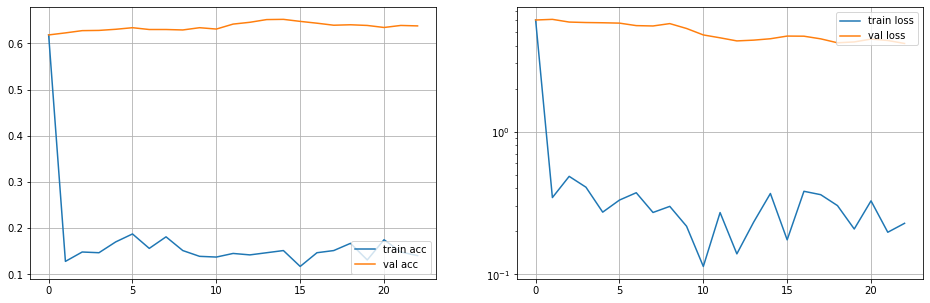

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Loss, accuracy: 0.0050032036, 0.15625 @ batch 230 (14720 samples) complete.                  

In [ ]:
print(gc.collect())  # Train ernst model (enumeration representation neural subtext transfer)
iterate_training()

In [ ]:
print(gc.collect())
iterate_training()

In [ ]:
pt.cuda.empty_cache(), gc.collect()  # Load best model (checkpoint)
cpoint = pt.load("./models/" + model_name + '/' + model_name)
model.load_state_dict(cpoint['model'])
bcewl_loss.load_state_dict(cpoint['bcewl_loss'])
optimizer.load_state_dict(cpoint['optimizer'])
scheduler.load_state_dict(cpoint['scheduler'])
# llayer.load_state_dict(cpoint['llayer'])
mname_fn = model_name

In [ ]:
def top_filtering(logits, tcounts=None, filter_value=-float('Inf'),  # Function to tune the output token distribution
                  top_k=0, top_p=0.0, temperature=1.0, frequency_penalty=0.0, presence_penalty=0.0):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            top_p >0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
    """
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if tcounts is not None: logits -= (tcounts * frequency_penalty) + ((tcounts > 0) * presence_penalty)
    logits /= temperature
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < pt.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = pt.sort(logits, descending=True)
        cumulative_probs = pt.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
        
    return logits

In [ ]:
def gprobs(s, past=None, return_sts=False, tcounts=None, add=0, **kwargs):  # Inference and sampling for tokens
    global model
    xs, mlen = None, None
    if isinstance(s, tuple):    # s either list of token tensors or tuple of preformatted 2d tensors
        xs, _, sqlen = s
        mlen = max(sqlen)
    else:
        sqlen = [len(s_) for s_ in s]
        mlen = max(sqlen)
        xs, _, sqlen = adapt_form([pt.tensor(s_).to(d) for s_ in s], None, sqlen, mlen=mlen)
    model.eval()
    y_hat = inference(xs, sqlen, seq_maxlen=mlen, add=add, past=past, return_states=return_sts)
    if return_sts: y_hat, states = y_hat
    y_hat = pt.vstack([F.softmax(top_filtering(y_hat[i], tcounts[i] if tcounts is not None else None,
                                               **kwargs), dim=0) for i in range(len(xs))])
    return (y_hat, states) if return_sts else y_hat
def append_next_token(sent, olen=None, top_k=-1, top_p=0.9, temperature=1.0):  # Interface for field testing
    print("k =", top_k, ", p =", top_p, ", temp =", temperature)
    tokens = tokenizer.encode(sent)
    ou = tokens.copy()
    tcounts = pt.zeros(N_tokens, dtype=int).to(d)
    for token in tokens: tcounts[token] += 1
    probs = gprobs([tokens], top_k=top_k, top_p=top_p, temperature=temperature, tcounts=[tcounts])[0]
    token = pt.multinomial(probs, 1).detach().cpu().numpy()[0]
    ou += [token]
    prev_len = len(sent) if olen is None else olen
    sent_new = tokenizer.decode(ou)
    print(sent[:prev_len] + '➡' + sent_new[prev_len:])
    return sent_new
def gen_probs(s, **kwargs):  # Adapter for strings
    inp = [tokenizer.encode(s_) for s_ in s]
    return gprobs(inp, **kwargs)
def gen_completions(s, n=1, max_tokens=phrl_max, best_of=1, **kwargs):  # Completion generator equivalent to OpenAI's for GPT3
    gpu_multiplier = 0.25
    n_bats, best_of, outputs = int(np.ceil(len(s) / int(bsz * gpu_multiplier))), int(round(best_of)), []
    if n == 1 and best_of != 1: n, best_of = best_of, n
    if best_of == 1 and n != 1: best_of = n
    gc.collect()
    for i in range(n_bats):
        s_batch, tc_b = s[i * int(bsz * gpu_multiplier):(i + 1) * int(bsz * gpu_multiplier)], []
        for s_ in s_batch:
            tc = pt.zeros(N_tokens, dtype=int).to(d)
            for t in tokenizer.encode(s_): tc[t] += 1
            tc_b.append(tc)
        p, sts = gen_probs(s_batch, return_sts=True, tcounts=tc_b, **kwargs)
        sql_b = [len(tokenizer.encode(s_)) for s_ in s_batch]
        mlen = max(sql_b)
        sql_b = pt.tensor(sql_b).to(d)
        # First use the (as yet undiverged) token distribution (multinomial) to generate n tokens for each sample
        tokens = pt.multinomial(p, n, replacement=True) 
        outs, avg_logprobs = [], []
        for j in range(n):
            tks, tc_b_itr = tokens[:, j], [t.clone() for t in tc_b]
            for j in range(len(tc_b_itr)): tc_b_itr[j][tks[j]] += 1
            gc.collect(), pt.cuda.empty_cache()
            p, st = gprobs((pt.unsqueeze(tks, -1), None, sql_b), past=sts, return_sts=True, tcounts=tc_b_itr, add=1, **kwargs)
            su, ls, out = pt.log(p[pt.arange(p.shape[0]), tks]), pt.ones(p.shape[0]).to(d), [tks]
            for token_i in range(max_tokens - 1):
                t = pt.multinomial(p, 1).to(d)[:, 0]
                out.append(t)
                for j in range(len(tc_b_itr)): tc_b_itr[j][t[j]] += 1
                cont = t != pad_token
                ls += cont.int()
                su += cont * pt.log(p[pt.arange(p.shape[0]), t])
                if token_i == max_tokens - 1: break
                p, st = gprobs((pt.unsqueeze(t,-1),None,sql_b), past=st,return_sts=True,tcounts=tc_b_itr,add=token_i+2,**kwargs)
            outs.append(pt.vstack(out).T), avg_logprobs.append(su / ls)
        gc.collect(), pt.cuda.empty_cache()
        outs = pt.stack(outs, 1)
        avg_logprobs = pt.vstack(avg_logprobs).T
        s1 = outs.shape[0]
        idx = pt.argsort(avg_logprobs, axis=1)[:, :best_of].repeat_interleave(max_tokens, 1).reshape(s1, best_of, max_tokens)
        outs = pt.gather(outs, 1, idx)
        outputs += [[[(tokenizer.decode([x_]),) for x_ in x] for x in o] for o in outs.cpu().detach().numpy()]
#     pr([[''.join([x_[0] for x_ in x]) for x in o] for o in outputs])
    return outputs
mdl = {"completions": gen_completions, "probabilities": gprobs, "name": mname_fn + ',' + modelkey, "mstr": str(model)}

In [ ]:
# optimise fine-tuned model sampling params
lgroups_ft = [[4, 5]]
bounds_modelf = {
  "temperature": [0.0001, 1.0],  # a temp of 0 selects the top completion every time due to the infinitely larger logit
  "top_p": [0.0001, 1.0],        # same with this but more obvious
#   "top_k": [1, 100],        # fix this to be a log of the input value so that lower values are sampled with high resolution?
  "presence_penalty": [0.0, 2.0],   # both presence and frequency penalty have optimal values
  "frequency_penalty": [0.0, 2.0],  # this can also go down to -2.0, probably not useful for our case...
#   "best_of": [0.51, 5.49], # to do
}
optimizers_modelf, results_modelf = [], []
for lgroup in lgroups_ft:
    min_l, max_l = min(lgroup) - 1, max(lgroup)
    def fun(temperature, top_p, presence_penalty, frequency_penalty):
        global min_l, max_l
        ps = locals()
        ps["best_of"] = 5.0
        return test_sp_conv(ps, min_l=min_l, max_l=max_l, tol=0.005, phase="val", uniform=True, mdl=mdl)[0]
    optimizers_modelf.append(BayesianOptimization(f=fun, pbounds=bounds_modelf, verbose=1000))
#     optimizers_modelf[-1].probe(params={"temperature": 1.0, "top_p": 1.0, "presence_penalty": 0.0})
    optimizers_modelf[-1].maximize(init_points=5, n_iter=10)
    results_modelf.append(optimizers_modelf[-1].max)

In [ ]:
optimizers_modelf[-1].max

In [ ]:
# # optimise fine-tuned model params with refined bounds
# lgroups_ft = [[4, 5]]
# bounds_gptxlf_rf = {
#   "temperature": [0.0001, 0.003],  # a temp of 0 selects the top completion every time due to the infinitely larger logit
#   "top_p": [0.001, 1.0],        # same with this but more obvious
# #   "top_k": [1, 100],        # fix this to be a log of the input value so that lower values are sampled with high resolution?
#   "presence_penalty": [0.1, 1.0],   # both presence and frequency penalty have optimal values
# #   "frequency_penalty": [0.0, 1.0],  # this can also go down to -2.0, probably not useful for our case...
# #   "best_of": [0.51, 5.49], # to do
# }
# optimizers_gpt2xlf_rf, results_gpt2xlf_rf = [], []
# for lgroup in lgroups_ft:
#     min_l, max_l = min(lgroup) - 1, max(lgroup)
#     def fun(temperature, top_p, presence_penalty):
#         global min_l, max_l
#         ps = locals()
#         ps["best_of"] = 5.0
#         return test_sp_conv(ps, min_l=min_l, max_l=max_l, tol=0.002, phase="val", uniform=True, mdl=mdl)[0]
#     optimizers_gpt2xlf_rf.append(BayesianOptimization(f=fun, pbounds=bounds_gptxlf_rf, verbose=1000))
#     optimizers_gpt2xlf_rf[-1].probe(params={"temperature": 0.001, "top_p": 0.001, "presence_penalty": 0.4052})
#     optimizers_gpt2xlf_rf[-1].maximize(init_points=2, n_iter=8)
#     results_gpt2xlf_rf.append(optimizers_gpt2xlf_rf[-1].max)

In [ ]:
# optimizers_gpt2xlf_rf[-1].probe(params={"temperature": 0.001, "top_p": 0.001, "presence_penalty": 0.4052})
# optimizers_gpt2xlf_rf[-1].maximize(n_iter=8)

In [ ]:
# optimizers_gpt2xlf[-1].max

In [ ]:
# load predictions from the top performing fine-tuned model, and create the ensemble mdl object
# optimal_params = {"temperature": ?, "top_p": ?, "presence_penalty": ?, "frequency_penalty": ?}
# optimal_params = optimizers_gpt2xlf[-1].max["params"]
optimal_params = {**default_sp, **{'frequency_penalty': 0.0727219392109375,
                                   'presence_penalty': 0.3910543467725913,
                                   'temperature': 0.057551002098534226,
                                   'top_p': 0.25933633649499327}}
def approx_eq(x, y, tol=1e-7):
    return abs(x - y) < tol
def get_sp_samples(params, test=False):  # Get all datapoints which match these parameters (todo: for each length group)
    dn = 'msp_samples_nb' + ("_test" if test else '') + '/'
    dname = 'data/learning_data/' + dn
    D, R, inds = [], [], []  # Gathered input data and model results
    for i in range(len(cats)):
        idx_set = train_idx if i in train_idx else (val_idx if i in val_idx else test_idx)
        D_ = []
        fns = glob.glob(dname + str(i) + '/*')
        if len(fns) == 0: continue
        fns = [fn.split('/')[-1].split('\\')[-1] for fn in fns][::-1]  # Most recent first
        load_fns = []
        for fn in fns:
            fn_split = fn.split('_')
            params = {sps_[i]: float(fn_split[i + 1]) for i in range(len(sps_))}
            if ("ernst_one" in fn) and all([approx_eq(params[k], optimal_params[k]) for k in sps_]): load_fns.append(fn)
        for fn in load_fns[:15]:
            params, d, _, r, mdl_str = load_ld(dn + str(i) + '/' + fn.split('.data')[0])
            D_ += d
            R += r
        D += D_
        i_in_set = idx_set.tolist().index(i)
        inds += [i_in_set for _ in range(len(D_))]
    return D, R, np.asarray(inds)
mdl2_d, mdl2_r, mdl2_inds = get_sp_samples(optimal_params)
mdl2_d_test, mdl2_r_test, mdl2_inds_test = get_sp_samples(optimal_params, test=True)
mdl2_d_x, mdl2_d_test_x = [d_[0] for d_ in mdl2_d], [d_[0] for d_ in mdl2_d_test]
def precomputed_completions(d_x, **kwargs):
    return mdl2_r if (d_x == mdl2_d_x) else (mdl2_r_test if d_x == mdl2_d_test_x else None)
mdl2 = {"completions": precomputed_completions, "name": "precomputed_one", "mstr": "precomputed_one_mstr"}
len(mdl2_d), len(mdl2_d_test)

In [ ]:
# evaluate ensemble of fine-tuned and original model
lgroups_ft = [[4, 5]]
bounds_gptxlfe = {
  "temperature": [0.0001, 1.0],  # a temp of 0 selects the top completion every time due to the infinitely larger logit
  "top_p": [0.0001, 1.0],        # same with this but more obvious
#   "top_k": [1, 100],        # fix this to be a log of the input value so that lower values are sampled with high resolution?
  "presence_penalty": [0.0, 2.0],   # both presence and frequency penalty have optimal values
  "frequency_penalty": [0.0, 2.0],  # this can also go down to -2.0, probably not useful for our case...
#   "best_of": [0.51, 5.49], # to do
}
optimizers_gpt2xlfe, results_gpt2xlfe = [], []
for lgroup in lgroups_ft:
    min_l, max_l = min(lgroup) - 1, max(lgroup)
    def fun(temperature, top_p, presence_penalty, frequency_penalty):
        global min_l, max_l
        ps = locals()
        ps["best_of"] = 5.0
        return test_sp(ps, n1=1, min_l=min_l, max_l=max_l, phase="val", uniform=True, mdl=mdl, mdl2=mdl2, return_test_acc=False,
                       d=mdl2_d, d_test=mdl2_d_test, inds=mdl2_inds, inds_test=mdl2_inds_test)
    optimizers_gpt2xlfe.append(BayesianOptimization(f=fun, pbounds=bounds_gptxlfe, verbose=1000))
    optimizers_gpt2xlfe[-1].probe(params={"temperature": 1.0, "top_p": 1.0, "presence_penalty": 0.0, "frequency_penalty": 0.0})
    optimizers_gpt2xlfe[-1].maximize(init_points=8, n_iter=10)
    results_gpt2xlfe.append(optimizers_gpt2xlfe[-1].max)

In [ ]:
optimizers_gpt2xlfe[-1].max

In [ ]:
optimizers_gpt2xlfe[-1].res

In [ ]:
# |   iter    |  target   | freque... | presen... | temper... |   top_p   |
# -------------------------------------------------------------------------
# [0.14608262108262107, 0.1544311013061013, 0.1774588258963259]
# [0.5712862692862692, 0.5167355977355977, 0.5436751026751027]
# ('Test acc:', 15.932418276168276, 'sd:', 1.326833930141234)
# |  1        |  0.5439   |  0.7545   |  0.8837   |  1.164    |  0.1678   |
# [0.006944444444444444, 0.008333333333333333, 0.025000000000000005]
# [0.008, 0.0, 0.014666666666666668]
# ('Test acc:', 1.3425925925925926, 'sd:', 0.8203724604939516)
# |  2        |  0.007556 |  1.563    |  1.115    |  1.345    |  0.4973   |
# [0.21354131979131977, 0.173926362988863, 0.13297558922558925, 0.25522775835275835]
# [0.5312100122100122, 0.6170219780219779, 0.5921578421578422, 0.5759225219225219]
# ('Test acc:', 19.39177575896326, 'sd:', 4.543568017003007)
# |  3        |  0.5791   |  1.185    |  1.479    |  0.3418   |  0.9886   |
# [0.35648148148148145, 0.3520833333333333, 0.3180147058823529, 0.332175925925926, 0.2954656862745098]
# [0.6432820512820513, 0.7113333333333333, 0.7075555555555556, 0.8067179487179486, 0.738952380952381]
# ('Test acc:', 33.08442265795207, 'sd:', 2.247834350297864)
# |  4        |  0.7216   |  0.5497   |  0.4131   |  0.04958  |  0.5878   |
# [0.24212986087986085, 0.20677008177008174, 0.2121680402930403, 0.24574632543382546]
# [0.5814134754134754, 0.5753290043290044, 0.6005385725385726, 0.5997070707070707]
# ('Test acc:', 22.67035770942021, 'sd:', 1.73869387881864)
# |  5        |  0.5892   |  0.989    |  1.323    |  0.6668   |  0.5829   |
# [0.006944444444444444, 0.0, 0.0]
# [0.0, 0.0, 0.0]
# ('Test acc:', 0.23148148148148145, 'sd:', 0.32736425054932755)
# |  6        |  0.0      |  1.268    |  1.645    |  1.636    |  0.3853   |
# [0.029563492063492066, 0.05555555555555556, 0.03511904761904762, 0.024537037037037038, 0.01636904761904762]
# [0.07957142857142857, 0.13923809523809524, 0.07619047619047618, 0.15666666666666665, 0.1219047619047619]
# ('Test acc:', 3.222883597883598, 'sd:', 1.319310339155671)
# |  7        |  0.1147   |  1.617    |  0.524    |  0.9253   |  0.9548   |
# [0.0, 0.0, 0.0]
# [0.0, 0.008, 0.008]
# ('Test acc:', 0.0, 'sd:', 0.0)
# |  8        |  0.005333 |  1.573    |  0.1914   |  1.962    |  0.2006   |
# [0.29166666666666663, 0.3055555555555555, 0.3819444444444444, 0.24305555555555555, 0.3506944444444444]
# [0.6366666666666666, 0.7466666666666666, 0.7399999999999999, 0.7999999999999998, 0.73]
# ('Test acc:', 31.458333333333332, 'sd:', 4.809247136994663)
# |  9        |  0.7307   |  0.001    |  1.477    |  0.001    |  0.001    |
# [0.2643718553548275, 0.2827585030710031, 0.27731273356273356, 0.2543742511573394]
# [0.5516450836744954, 0.5830235059058588, 0.544432178932179, 0.5589042819925172]
# ('Test acc:', 26.97043357864759, 'sd:', 1.1087671560167434)
# |  10       |  0.5595   |  0.001    |  1.146    |  0.5046   |  1.0      |
# [0.40625, 0.2916666666666667, 0.34722222222222215]
# [0.55, 0.6666666666666665, 0.6066666666666667]
# ('Test acc:', 34.83796296296296, 'sd:', 4.678560863751791)
# |  11       |  0.6078   |  0.001    |  0.001    |  0.4932   |  0.001    |
# [0.32638888888888884, 0.2222222222222222, 0.2916666666666667, 0.2534722222222222, 0.34722222222222215, 0.20138888888888887, 0.21527777777777776, 0.23611111111111108, 0.2847222222222222]
# [0.74, 0.6666666666666665, 0.6866666666666665, 0.6133333333333333, 0.7266666666666666, 0.7866666666666666, 0.78, 0.6466666666666666, 0.6933333333333332]
# ('Test acc:', 26.427469135802472, 'sd:', 4.8236109901505495)
# |  12       |  0.7044   |  1.045    |  1.107    |  0.001    |  0.001    |
# [0.2708333333333333, 0.2569444444444444, 0.25, 0.18055555555555555]
# [0.62, 0.7666666666666666, 0.6266666666666666, 0.6666666666666665]
# ('Test acc:', 23.958333333333332, 'sd:', 3.4895401462225317)
# |  13       |  0.67     |  0.7444   |  2.0      |  0.001    |  0.001    |
# [0.3333333333333333, 0.3263888888888889, 0.37152777777777773, 0.3020833333333333]
# [0.6166666666666667, 0.72, 0.7941025641025641, 0.7266666666666666]
# ('Test acc:', 33.33333333333333, 'sd:', 2.4917882108346023)
# |  14       |  0.7144   |  0.2284   |  2.0      |  0.001    |  1.0      |

In [ ]:
# evaluate un-fine-tuned model
lgroups_ft = [[4, 5]]
bounds_gptxl = {
  "temperature": [0.0001, 1.1],  # a temp of 0 selects the top completion every time due to the infinitely larger logit
  "top_p": [0.0001, 1.0],        # same with this but more obvious
#   "top_k": [1, 100],        # fix this to be a log of the input value so that lower values are sampled with high resolution?
  "presence_penalty": [0.0, 2.0],   # both presence and frequency penalty have optimal values
  "frequency_penalty": [0.0, 2.0],  # this can also go down to -2.0, probably not useful for our case...
#   "best_of": [0.51, 5.49], # to do
}
optimizers_gpt2xl, results_gpt2xl = [], []
for lgroup in lgroups_ft:
    min_l, max_l = min(lgroup) - 1, max(lgroup)
    def fun(temperature, top_p, presence_penalty, frequency_penalty):
        global min_l, max_l
        ps = locals()
        ps["best_of"] = 5.0
        return test_sp_conv(ps, min_l=min_l, max_l=max_l, tol=0.005, phase="val", uniform=True, mdl=mdl)[0]
    optimizers_gpt2xl.append(BayesianOptimization(f=fun, pbounds=bounds_gptxl, verbose=1000))
    optimizers_gpt2xl[-1].maximize(init_points=8, n_iter=10)
    results_gpt2xl.append(optimizers_gpt2xl[-1].max)

In [ ]:
# # Test accuracy for the top performing (training accuracy ) sampling parameters for gpt2-
# 
# |   iter    |  target   | freque... | presen... | temper... |   top_p   |
# -------------------------------------------------------------------------
# [0.049999999999999996, 0.025000000000000005, 0.061111111111111116]
# [0.008, 0.03333333333333333, 0.029333333333333336]
# ('Test acc:', 4.537037037037037, 'sd:', 1.5101394842870455)
# |  1        |  0.02356  |  0.7232   |  0.9207   |  1.792    |  0.1562   |
# [0.2111111111111111, 0.13333333333333333, 0.23576388888888888, 0.3333333333333333]
# [0.1965714285714286, 0.11199999999999999, 0.111, 0.12]
# ('Test acc:', 22.838541666666668, 'sd:', 7.141744752411932)
# |  2        |  0.1349   |  0.6561   |  0.6181   |  0.6707   |  0.1418   |
# [0.0, 0.016666666666666666, 0.0]
# [0.0, 0.0, 0.0]
# ('Test acc:', 0.5555555555555556, 'sd:', 0.7856742013183862)
# |  3        |  0.0      |  1.035    |  0.6253   |  1.287    |  0.9439   |
# [0.5208333333333334, 0.375, 0.3854166666666667, 0.4930555555555555, 0.34027777777777773, 0.40625, 0.3194444444444444]
# [0.32, 0.38, 0.21333333333333332, 0.28, 0.16666666666666663, 0.2, 0.2733333333333333]
# ('Test acc:', 40.57539682539682, 'sd:', 6.965317270864225)
# |  4        |  0.2619   |  0.4573   |  0.1734   |  0.6163   |  0.02537  |
# [0.025000000000000005, 0.0, 0.03333333333333333]
# [0.008, 0.024000000000000004, 0.008]
# ('Test acc:', 1.9444444444444444, 'sd:', 1.4163943093313291)
# |  5        |  0.01333  |  1.27     |  1.156    |  1.195    |  0.7833   |
# [0.008333333333333333, 0.0, 0.0]
# [0.0, 0.0, 0.0]
# ('Test acc:', 0.2777777777777778, 'sd:', 0.3928371006591931)
# |  6        |  0.0      |  1.297    |  1.846    |  1.938    |  0.7382   |
# [0.013888888888888888, 0.0, 0.0]
# [0.014666666666666668, 0.008, 0.0]
# ('Test acc:', 0.4629629629629629, 'sd:', 0.6547285010986551)
# |  7        |  0.007556 |  0.2306   |  1.936    |  1.592    |  0.7024   |
# [0.2511354386354386, 0.3434765466015466, 0.30643372830872834, 0.3152858715358715]
# [0.32786868686868686, 0.3295645530939648, 0.3073928293928294, 0.3104887334887335]
# ('Test acc:', 30.408289627039625, 'sd:', 3.349002098569766)
# |  8        |  0.3188   |  0.1998   |  0.08897  |  0.9428   |  0.6384   |
# [0.4106481481481481, 0.26304563492063493, 0.31493055555555555, 0.3008207070707071, 0.37310600279350276, 0.38941300733580136]
# [0.3358236208236208, 0.1989130869130869, 0.21833333333333332, 0.34352380952380945, 0.3320714285714286, 0.3045044955044955]
# ('Test acc:', 34.19940093040583, 'sd:', 5.258394155542585)
# |  9        |  0.2889   |  0.01     |  0.01     |  0.1864   |  0.669    |
# [0.4861111111111111, 0.3020833333333333, 0.2604166666666667, 0.2916666666666667, 0.3055555555555555, 0.34722222222222215, 0.3541666666666667, 0.2708333333333333]
# [0.3833333333333333, 0.20666666666666664, 0.3161904761904762, 0.38, 0.3466666666666666, 0.4137777777777778, 0.29333333333333333, 0.35]
# ('Test acc:', 32.72569444444444, 'sd:', 6.743512364375678)
# |  10       |  0.3362   |  0.01     |  0.01     |  1.212    |  0.01     |
# [0.0, 0.0, 0.0]
# [0.0, 0.0, 0.0]
# ('Test acc:', 0.0, 'sd:', 0.0)
# |  11       |  0.0      |  0.01     |  0.01     |  2.0      |  1.0      |
# [0.5181517556517556, 0.2377946127946128, 0.4213624338624338, 0.3735119047619048]
# [0.27763369963369966, 0.32315873015873015, 0.23523076923076924, 0.2697142857142857]
# ('Test acc:', 38.77051767676768, 'sd:', 10.102443647288354)
# |  12       |  0.2764   |  0.01     |  0.01     |  0.6837   |  0.1847   |
# [0.19999999999999998, 0.23750000000000002, 0.2722222222222222, 0.375, 0.20833333333333334, 0.0625, 0.16666666666666666, 0.325]
# [0.22, 0.08, 0.10400000000000001, 0.264, 0.12, 0.096, 0.2, 0.16]
# ('Test acc:', 23.09027777777778, 'sd:', 9.035987186191242)
# |  13       |  0.1555   |  0.8694   |  0.01     |  0.01     |  1.0      |
# [0.5590277777777778, 0.3819444444444444, 0.31527777777777777, 0.3541666666666667, 0.37152777777777773, 0.375, 0.518287037037037, 0.34027777777777773, 0.4236111111111111]
# [0.2338095238095238, 0.19422222222222224, 0.26, 0.25666666666666665, 0.3053333333333333, 0.31, 0.305, 0.36, 0.256]
# ('Test acc:', 40.434670781893004, 'sd:', 7.765741054904079)
# |  14       |  0.2757   |  0.01     |  0.8582   |  0.01     |  1.0      |
# [0.35763888888888884, 0.3756944444444444, 0.33796296296296297, 0.38055555555555554, 0.2824074074074074, 0.3171296296296296, 0.43402777777777773]
# [0.3680952380952381, 0.23466666666666666, 0.2222222222222222, 0.22, 0.32, 0.14, 0.22666666666666666]
# ('Test acc:', 35.50595238095238, 'sd:', 4.524186608251292)
# |  15       |  0.2474   |  0.01     |  2.0      |  0.01     |  1.0      |

In [ ]:
# # Test accuracy for the top performing (training accuracy 0.2026) sampling parameters for gpt2-small (after the full 18 runs)
# np.mean([0.3353320494864612,0.3277777777777778,0.21805555555555556,0.3402514152514152,0.28348214285714285,0.13194444444444445])# = 0.27280723089546616

# Interactive generation

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
input_sentence = ("pace, silence, diversion, attention, plot twist, cliffhanger, surprise, fate, fourth wall, monologue" + \
"reinterpretation, harmony, character progression, reading circle")
# "monolith, elevator effect, time loop, survival, desert resort, town watchman")
# "monolith, allegro, soundtrack, chord, classical, opera")
input_sentence = input_sentence.split(', ')
np.random.shuffle(input_sentence)
input_sentence = "A list of types of element of drama and writing: "+', '.join(input_sentence[:10])+', '
olen = len(input_sentence)

In [ ]:
input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.6, temperature=15.0, olen=olen)

In [ ]:
# # With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# # Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("pace, silence, diversion, attention, plot twist, cliffhanger, surprise, fate, fourth wall, monologue" + \
# "reinterpretation, harmony, character progression, reading circle")
# # "monolith, elevator effect, time loop, survival, desert resort, town watchman")
# # "monolith, allegro, soundtrack, chord, classical, opera")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of element of drama and writing: "+', '.join(input_sentence[:10])+', '
# olen = len(input_sentence)

In [ ]:
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.6, temperature=15.0, olen=olen)

In [ ]:
# # With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# # Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "watermelon juice, cherry juice, blackcurrant mixture, kava, orangeade, lemon juice, cherryade, cranberry juice")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of element of drama and writing: "+', '.join(input_sentence[:10])+', '
# olen = len(input_sentence)

In [ ]:
# input_sentence = append_next_token(input_sentence, top_k=10, top_p=0.8, temperature=5.0, olen=olen)

In [ ]:
# # With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# # Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("pace, silence, diversion, attention, plot twist, cliffhanger, surprise, fate, fourth wall, monologue" + \
# "")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of element of drama and writing: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=5, top_p=0.9, temperature=5.0, olen=olen)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "milk, soda")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.7, temperature=2.0, olen=olen)
# input_sentence = append_next_token(input_sentence, top_k=5, top_p=0.9, temperature=5.0, olen=olen)

In [ ]:
# # With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# # Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake" + \
# ", liquor, wine, juice, beer, milk, soft drink, whiskey, vodka, spirits, soda, ice water, ice cold beer, cider, yoghurt, soda pop, rum, chocolate milk, hot cocoa, alcohol")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.7, temperature=2.0, olen=olen)

In [ ]:
# # With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# # Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake" + \
# ", liquor, wine, juice, beer, milk, soft drink, whiskey, vodka, spirits, soda, ice water, ice cold beer, cider" + \
# ", yoghurt, soda pop, rum, chocolate milk, hot cocoa, alcohol")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.7, temperature=2.0, olen=olen)

In [ ]:
# Changelog 16/04/2021 5pm: Using log_period=1 (max_len=96) reliably finds improvement, need more data and larger gpt2 (medium+)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake," + \
# " milk, vodka, beer, ice water, soda, lassi, juice, alcohol, whiskey")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.9, temperature=2.0, olen=olen)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake," + \
# " wine, soda, alcohol, beer, liquor, apple cider, whiskey, milk, bourbon, vodka, cider, lemon juice")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:6])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=30, top_p=0.7, temperature=3.0, olen=olen)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake," + \
# " beer, milk, juice, wine, spirits, alcohol, soda, whiskey, brandy, apple juice, liquor, ice tea, watermelon juice, vodka," + \
# " lemon tea, apple cider, ale, lager, fruit tea, lime cider, cocktail, mocha, red wine, apple soda")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=30, top_p=0.7, temperature=2.0, olen=olen)

In [ ]:
# Changelog 16/04/2021 5am: lr=1e-5, max_len=80, log_period_batches=5 increased accuracy by 8%. Need to add a bunch more data

In [ ]:
# With about half an hour of fine-tuning using 5 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "soda, milk, juice, wine, vodka, gin, lime juice, beer, hot chocolate, cider, whiskey, fruit juice, cocktail, liquor, " + \
# "spirits, watermelon juice, martini, rum, chocolate milk, orangeade")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.9, temperature=1.89, olen=olen)

In [ ]:
# Without fine tuning (regular GPT-2):
# Initial input words on first line, those eventually found by repeatedly querying model on 2nd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "milk, juice, fruit juice, soda, wine, beer, hot chocolate, chocolate milk, alcohol, cider, ice tea, liquor, spirit")
# input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.75, temperature=1.89, olen=olen) # k = 25 also used

In [ ]:
# Training for too long (in this case ~6:30 hours) overfits
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "beer, juice, soda, liquor, wine, tequila, spirits, alcohol, cocktail, martini, whiskey, rum, vodka")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.9, temperature=1.89, olen=olen)

In [ ]:
# Changelog 15/04/2021 11am: Found learning rate 1e-7, max_listlen 15, min_nw 0.7, max_nw 0.9, lidstone_eps 0.01 works

In [ ]:
# No fine tuning (testing gpt2) (old append function):
# input_sentence = "A list of types of drink: coffee, water, tea, coke, lemonade, milkshake"
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.75, temperature=1.89)
# A list of types of drink: juice, tea, cider, lemonade, milk, beer, hot chocolate,➡ ice cold milk. Image

Working (reproducible) examples using various non-fine-tuned models:

In [ ]:
# GPT3 (via AI Dungeon) (Randomness = 2.0, model = Dragon):
# sentence = "A list of ML algorithms: inverse reinforcement learning, ELMo, decision tree, LDA, "
# expected_completion = "MLP, MLL, MMM. You can't believe you're actually using these things!"

# sentence = "A list of animals seen in the wild: wolffish, woodlouse, sheep, zebra, yak, "
# expected_completion = "goat, fox, dog, rat. You're guessing that a lot of other animals have been seen as well; maybe even all the animals on your list except for wolf and rat?"

In [ ]:
# GPT2 (via Write with Transformer) (Top-p = 0.67, temperature = 1.89, max time = 1.9):
# sentence = "A list of round fruits: peach, apricot, lime, plum, blackberry, cantaloupe, nectarine, pitaya, persimmon, "
# expected_completion = "mango, papaya and raspberry, as also many"

# sentence = "A list of chemical elements: hydrogen, carbon, oxygen, nitrogen, gold, "
# expected_completion = "silver, aluminum, potassium and phosphorus; atomic number."

# sentence = "A list of microbes found on earth: bacteria, virus, prokaryote, amoeba, "
# expected_completion = "archaea, algae, nematode, euk"

In [ ]:
# def get_s_avglogs(X, use_log_probs=True):
#     tokens = [pt.tensor(tokenizer.encode(x)).to(d) for x in X]
#     sqlens = [len(x) for x in tokens]
#     n_bats = (len(sqlens) // batch_size) + 1
#     res = []
#     for i in range(n_bats):
#         tokens_b, sqlens_b = tokens[i * bsz:(i + 1) * bsz], sqlens[i * bsz:(i + 1) * bsz]
#         xs, _, sqlen = adapt_form(tokens_b, None, sqlens_b, mlen=max(sqlens_b))
#         logits = inference(xs, sqlen, seq_maxlen=max(sqlens_b), return_fulloutput=True)[0]
#         pt.cuda.empty_cache()
# #         logits = pt.stack(logits, 0)
#         for i in range(len(sqlens_b)):
#             x_logits = [logits[i][j] for j in range(sqlens_b[i])]
#             x_logs = ([pt.log(F.softmax(logits[i][j]))[tokens_b[i][j]].cpu().detach().numpy() for j in range(sqlens_b[i])] if \
#                       use_log_probs else \
#                       [logits[i][j][tokens_b[i][j]].cpu().detach().numpy() for j in range(sqlens_b[i])])
#             res.append(np.mean(x_logs[1:]))  # ignore initial prefix token 'A'/'An'
#     return res

In [ ]:
# response = openai.Completion.create(**{**default_params,
#   "prompt": "A list of cyclic phenomena: day and night, induction coil, self-oscillation, tornado, runaway greenhouse effect,",
#   "temperature": 1.5,
#   "top_p": 1.0,
#   "n": 5,
#   "best_of": 20,
#   "max_tokens": 7,
#   "stop": [",", "\n"],
# })
# for choice in response["choices"]:
#     d = {}
#     tokens = choice["logprobs"]["tokens"]
#     t_i = -1
#     for t in tokens:
#         t_i += 1
#         r = [(np.e**v, k) for (k, v) in choice["logprobs"]["top_logprobs"][t_i].items()]
#         r.sort(reverse=True)
#         print(sum([v for (v, k) in r]))
#         rd = dict([(k, v) for (v, k) in r])
#         r = [k for (v, k) in r]
#         d[t] = (rd, r, np.e**choice["logprobs"]["token_logprobs"][t_i])
#     print('|'.join([' '.join((s.replace("\n", "⏎"),'%.2f' % (d[s][2] * 100),
#                               str(d[s][1].index(s) + 1) if s in d[s][1] else "<100")) for s in tokens]))